# 目的
- 購入者の効果、貢献度を評価する

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

import ChocoUtils as util

In [2]:
# jupyterの日本語設定
import matplotlib
from matplotlib.font_manager import FontProperties

font_path = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf' #ubuntu
#font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc' #mac
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

# データロード

In [3]:
HOME = '/home/yoichi/work/choco-ball'  # ubuntu
#HOME = '/Users/tokita/workspace/etc/choco-ball-statistics'  # mac
db_file = os.path.join(HOME, 'data/choco-ball.db')
f_str = 'campaign is not 1 or campaign is 1'
p_data = util.get_data(db_file=db_file, filter_str=f_str)
data = p_data.drop(columns='shop')
data[:3]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1 or campaign is 1;
Shape of MeasurementData(record_num, n_columns) : (411, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,angel,campaign,taste,buyer,net_weight,mean_weight
0,2017-11-19,None,None,34.002,4.756,16,小山工場,0,1,0,時田,29.246,1.827875
1,2017-11-20,None,None,34.435,4.805,17,小山工場,0,1,0,時田,29.630,1.742941
2,2017-11-21,2018-06-01,None,34.000,4.815,18,小山工場,0,1,0,時田,29.185,1.621389


In [4]:
# 銀のエンゼルのフラグデータ
data['silver'] = [1 if a == 1 else 0 for a in data['angel'].values]
# 金のエンゼル
data['gold'] = [1 if a == 2 else 0 for a in data['angel'].values]

# 購入者の調整
data['buyer'] = ['ピシャイ' if a in 'ピシャイ/佐藤' else a for a in data['buyer'].values]

"""
data['buyer'] = ['筆者' if a in '時田' else a for a in data['buyer'].values]
data['buyer'] = ['同僚A' if a in '西田' else a for a in data['buyer'].values]
data['buyer'] = ['同僚B' if a in 'ピシャイ' else a for a in data['buyer'].values]
data['buyer'] = ['同僚C' if a in '根本' else a for a in data['buyer'].values]
data['buyer'] = ['同僚D' if a in '大谷' else a for a in data['buyer'].values]
data['buyer'] = ['同僚E' if a in '岡崎' else a for a in data['buyer'].values]
"""

data['ones'] = 1

In [5]:
data.pivot_table(index=['buyer'], columns=['angel'], values='ones', fill_value=0, aggfunc=lambda x:len(x))

angel,0,1,2
buyer,,,
ピシャイ,81,5,1
嘉瀬,1,0,0
大谷,4,1,0
岡崎,2,0,0
時田,230,6,0
根本,8,0,0
直美,1,0,0
西田,69,2,0


# 購入者別のエンゼル出現確率

In [6]:
import pymc as pm
import scipy.stats as stats

In [11]:
def getMCMCResult(data, n_sample=35000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Uniform('p', lower=0, upper=1)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)

    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)

    return mcmc.trace('p')[:]

 [-----------------100%-----------------] 35000 of 35000 complete in 1.7 secピシャイ : 0.07242599625663966


/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


 [-----------------100%-----------------] 35000 of 35000 complete in 1.7 sec時田 : 0.04592680360076015
 [-----------------100%-----------------] 35000 of 35000 complete in 1.6 sec西田 : 0.04910860343275227


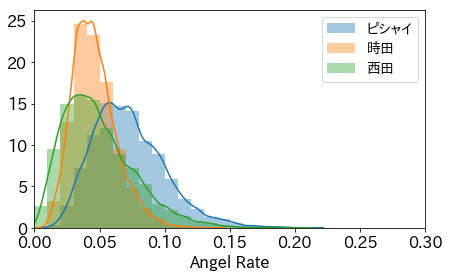

In [15]:
grp = data[data['campaign'] != 1].groupby(['buyer'])
g_cnt = len(grp.groups.keys())

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

cnt = 0
for key, group in grp:
    if group.shape[0] < 6:
        continue
    p_dist_silver = pd.Series(getMCMCResult(group['silver']))
    sns.distplot(p_dist_silver, ax=ax, label=key, bins=np.arange(0.0, 0.8, 0.01))
    print('{} : {}'.format(key, p_dist_silver.mean()))
    cnt+=1
ax.legend(fontsize=14)
ax.set_xlabel('Angel Rate', fontsize=16)
ax.set_xlim([0.0, 0.3])
ax.tick_params(labelsize=16)

#fig.savefig('../fig/estimate_angel_rate_buyer_20180515.png')
fig.savefig('estimate_angel_rate_buyer_20181220.png')

 [-----------------100%-----------------] 35000 of 35000 complete in 1.7 secピシャイ : 0.06710437273165074


/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


 [-----------------100%-----------------] 35000 of 35000 complete in 1.9 sec時田 : 0.029346174863136783
 [-----------------100%-----------------] 35000 of 35000 complete in 1.7 sec西田 : 0.04109693891468985


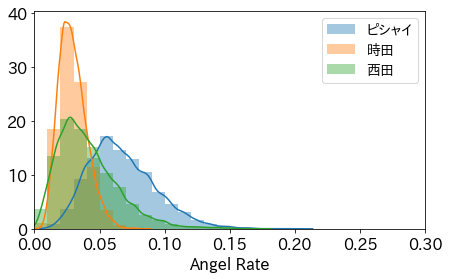

In [14]:
grp = data.groupby(['buyer'])
g_cnt = len(grp.groups.keys())

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

cnt = 0
for key, group in grp:
    if group.shape[0] < 10:
        continue
    p_dist_silver = pd.Series(getMCMCResult(group['silver']))
    sns.distplot(p_dist_silver, ax=ax, label=key, bins=np.arange(0.0, 0.8, 0.01))
    print('{} : {}'.format(key, p_dist_silver.mean()))
    cnt+=1
ax.legend(fontsize=14)
ax.set_xlabel('Angel Rate', fontsize=16)
ax.set_xlim([0.0, 0.3])
ax.tick_params(labelsize=16)

fig.savefig('estimate_angel_rate_buyer_20181220_all.png')

## β分布を事前分布に

In [ ]:
x = np.linspace(0.0, 0.999, 1000)
y = stats.beta.pdf(x, 2, 15)
plt.plot(x, y)
pd.DataFrame({'x':x, 'y':y}).sort_values(by=['y'], ascending=False)[:3]

#plt.savefig('./fig/beta_dist.png')

In [ ]:
def getMCMCResultBeta(data, n_sample=15000, n_burn=5000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    # 出現確率pの事前分布
    p = pm.Beta('p', alpha=2, beta=15)
    # 観測を結びつける
    obs = pm.Bernoulli('obs', p, value=data, observed=True)

    # MCMC
    # Modelオブジェクト生成
    model = pm.Model([p, obs])
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)

    return mcmc.trace('p')[:]

In [ ]:
grp = data[data['campaign'] != 1].groupby(['buyer'])

fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

for key, group in grp:
    if group.shape[0] < 6:
        continue
    p_dist_silver = pd.Series(getMCMCResultBeta(group['silver']))
    sns.distplot(p_dist_silver, ax=ax, label=key, bins=np.arange(0.0, 0.8, 0.01))
ax.legend(fontsize=14)
ax.set_xlabel('Engel Rate', fontsize=16)
ax.set_xlim([0.0, 1.0])
ax.tick_params(labelsize=16)

fig.savefig('../fig/estimate_angel_rate_buyer_beta_20180515.png')